In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score
from scipy import stats
from scipy.stats import norm
from scipy.stats import binned_statistic
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import scipy.stats as sps



# Preprocessing

We will get the data and break it down removing unnecessary data.

In [2]:
gamePlays = pd.read_csv('./game_plays.csv', low_memory=False)
gamePlays.shape

(2369646, 20)

The original game_plays.csv file included 2,369,646 rows of events. We are not interested in the events: early intermission end, emergency goaltender, game end, game scheduled, official challenges, penalties, period end. We also don't want to keep anything past period 4, which is shoot outs.

In [3]:
gamePlays = gamePlays[gamePlays['event'].isin(['Goal', 'Shot', 'Missed Shot','Blocked Shot'])]
gamePlays = gamePlays[gamePlays.period <= 5]
gamePlays.shape

(832330, 20)

We were able to drop roughly 500,000 rows of unnecessary data.

Next we look at the columns. Most of these are unnecessary so we will specify the ones we want to keep.

In [4]:
gamePlays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832330 entries, 8 to 2369642
Data columns (total 20 columns):
play_id                832330 non-null object
game_id                832330 non-null int64
play_num               832330 non-null int64
team_id_for            832330 non-null float64
team_id_against        832330 non-null float64
event                  832330 non-null object
secondaryType          446890 non-null object
x                      832278 non-null float64
y                      832279 non-null float64
period                 832330 non-null int64
periodType             832330 non-null object
periodTime             832330 non-null int64
periodTimeRemaining    832330 non-null int64
dateTime               832330 non-null object
goals_away             832330 non-null int64
goals_home             832330 non-null int64
description            832330 non-null object
st_x                   832278 non-null float64
st_y                   832279 non-null float64
rink_side      

In [5]:
dataComplete = gamePlays.filter(items=['game_id', 'x', 'y', 'period', 'periodTime', 'event', 'secondaryType'])
dataComplete.head()

,game_id,x,y,period,periodTime,event,secondaryType
8,2012030221,-73.0,8.0,1,35,Blocked Shot,NaN
12,2012030221,-67.0,11.0,1,74,Blocked Shot,NaN
15,2012030221,56.0,37.0,1,132,Shot,Snap Shot
16,2012030221,-34.0,-32.0,1,139,Shot,Slap Shot
18,2012030221,-36.0,-34.0,1,170,Shot,Wrist Shot


After trimming the columns we now have isolated the events that we will need as well as the categories we will use.

# Organizing, Creating and Dropping Data

First we rotate all of the shot data as to have it all on one side of the rink. This keeps the data accurate to the side that shots are made from, which is important due to some players and teams preferring one side of the ice based on "handedness".

In [6]:
negativeX = np.zeros(dataComplete.shape[0])
negativeX = np.where(dataComplete.x < 0, -1, 1)
dataComplete.x = np.multiply(dataComplete.x, negativeX)
dataComplete.y = np.multiply(dataComplete.y, negativeX)

Then we create a new binary category to show if a shot is a goal or not.

In [7]:
dataComplete['is_goal'] = np.where(dataComplete['event'] == 'Goal', 1, 0)
dataComplete['is_shot'] = np.where(dataComplete['event'] == 'Shot', 1, 0)
dataComplete['BlockedShot'] = np.where(dataComplete['event'] == 'Blocked Shot', 1, 0)
dataComplete['MissedShot'] = np.where(dataComplete['event'] == 'Missed Shot', 1, 0)
dataComplete['SnapShot'] = np.where(dataComplete['secondaryType'] == 'Snap Shot', 1, 0)
dataComplete['SlapShot'] = np.where(dataComplete['secondaryType'] == 'Slap Shot', 1, 0)
dataComplete['WristShot'] = np.where(dataComplete['secondaryType'] == 'Wrist Shot', 1, 0)
dataComplete['Tip'] = np.where(dataComplete['secondaryType'] == 'Tip-In', 1, 0)
dataComplete['Deflected'] = np.where(dataComplete['secondaryType'] == 'Deflected', 1, 0)

We also create a distance column with Euclidean distance from the net of a goal. At the same time we drop any null x and y because we won't need those.

In [8]:
dataComplete = dataComplete.dropna(subset=['x', 'y'])
dataComplete['distance'] = np.sqrt((dataComplete.x - 89)**2 + dataComplete.y**2)
dataComplete.head()

,game_id,x,y,period,periodTime,event,secondaryType,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,distance
8,2012030221,73.0,-8.0,1,35,Blocked Shot,NaN,0,0,1,0,0,0,0,0,0,17.888544
12,2012030221,67.0,-11.0,1,74,Blocked Shot,NaN,0,0,1,0,0,0,0,0,0,24.596748
15,2012030221,56.0,37.0,1,132,Shot,Snap Shot,0,1,0,0,1,0,0,0,0,49.578221
16,2012030221,34.0,32.0,1,139,Shot,Slap Shot,0,1,0,0,0,1,0,0,0,63.631753
18,2012030221,36.0,34.0,1,170,Shot,Wrist Shot,0,1,0,0,0,0,1,0,0,62.968246


We have picked a couple types of zones to use as bins for categorical data exploration. The first is based on distance. The second is based on high risk shot zones.

In [9]:
conditions = [
    (dataComplete['x'] <= 25),
    (dataComplete['x'] > 89),
    (dataComplete['distance'] < 10),
    (dataComplete['distance'] < 20),
    (dataComplete['distance'] < 30),
    (dataComplete['distance'] < 40),
    (dataComplete['distance'] < 50)
]

choices = [3.31862, 10.885609, 17.890776, 8.388211, 4.856358, 3.412389, 2.291195]
dataComplete['trueShotPercent'] = np.select(conditions, choices, default=1.198118)

In [10]:
conditions = [
    (dataComplete['x'] <= 25),
    (dataComplete['x'] > 89),
    (dataComplete['distance'] < 10),
    (dataComplete['distance'] < 20),
    (dataComplete['distance'] < 30),
    (dataComplete['distance'] < 40),
    (dataComplete['distance'] < 50)
]

choices = [7, 8, 1, 2, 3, 4, 5]
dataComplete['zone1'] = np.select(conditions, choices, default=6)


In [11]:
conditions = [
    (dataComplete['x'] < 25),
    ((dataComplete['x'] < 54) & (dataComplete['y'] >= 8)),
    ((dataComplete['x'] < 54) & (dataComplete['y'] <= -8)),
    (dataComplete['x'] < 54),
    ((dataComplete['x'] < 69) & (dataComplete['y'] >= 22)),
    ((dataComplete['x'] < 69) & (dataComplete['y'] >= 8)),
    ((dataComplete['x'] < 69) & (dataComplete['y'] <= -22)),
    ((dataComplete['x'] < 69) & (dataComplete['y'] <= -8)),
    (dataComplete['x'] < 69),
    ((dataComplete['x'] < 89) & (abs(dataComplete['y']) >= (dataComplete['x']*(-14/20)+(703/10))) & (dataComplete['y'] >= 0)),
    ((dataComplete['x'] < 89) & (abs(dataComplete['y']) >= (dataComplete['x']*(-14/20)+(703/10)))),
    ((dataComplete['x'] < 89) & (dataComplete['y'] >= 8)),
    ((dataComplete['x'] < 89) & (dataComplete['y'] <= -8)),
    ((dataComplete['x'] < 89) & (dataComplete['x'] < 79)),
    (dataComplete['x'] < 89)
]

choices = ['Behind-Blue', 'L-Point', 'R-Point', 'C-Point', 'L-1', 'L-2', 'R-1', 'R-2', 'High-Slot', 'L-Low', 'R-Low', 'L-Slot', 'R-Slot', 'Slot', 'Low-Slot']
dataComplete['zone2'] = np.select(conditions, choices, default='Down-Low')
dataComplete.head()

,game_id,x,y,period,periodTime,event,secondaryType,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,distance,trueShotPercent,zone1,zone2
8,2012030221,73.0,-8.0,1,35,Blocked Shot,NaN,0,0,1,0,0,0,0,0,0,17.888544,8.388211,2,R-Slot
12,2012030221,67.0,-11.0,1,74,Blocked Shot,NaN,0,0,1,0,0,0,0,0,0,24.596748,4.856358,3,R-2
15,2012030221,56.0,37.0,1,132,Shot,Snap Shot,0,1,0,0,1,0,0,0,0,49.578221,2.291195,5,L-1
16,2012030221,34.0,32.0,1,139,Shot,Slap Shot,0,1,0,0,0,1,0,0,0,63.631753,1.198118,6,L-Point
18,2012030221,36.0,34.0,1,170,Shot,Wrist Shot,0,1,0,0,0,0,1,0,0,62.968246,1.198118,6,L-Point


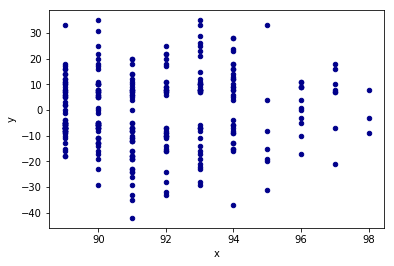

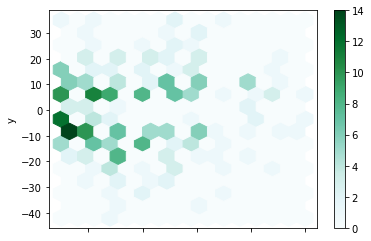

In [12]:
goals = dataComplete[dataComplete['zone2'].isin(['Down-Low'])]
goals = goals[goals['event'].isin(['Goal'])]
ax1 = goals.plot.scatter(x='x', y='y', c='DarkBlue')
goalsdf=goals[['x','y']]
goalsdf = goalsdf.reset_index(drop=True)
goalsdf.plot.hexbin(x='x', y='y', gridsize=15)

TODO: Create 3 dataframes:
        One without Missed and Blocked b/c it doesn't have secondary data
        One with that deletes secondary data and doesn't use it
        One with secondary data null that will be transformed with guesses of the values of type of shot

# Creating Training and Testing Dataframes

We are using everything from the 2012/13 season to the 2015/16 season for training and everything after that for testing.

In [13]:
# Training set data for all shots
trainData = dataComplete.loc[dataComplete['game_id'] < 2016930000]
#dataComplete['is_goal'] = np.where(dataComplete['event'] == 'Goal', 1, 0)
#dataComplete['is_shot'] = np.where(dataComplete['event'] != 'Goal', 1, 0)

# Testing set data for all shots
testData = dataComplete.loc[dataComplete['game_id'] >= 2016930000]

In [14]:
#important to note that is_goal has to be moved to the end of the data set before arffed then the @attribute is_goal integer line has to be deleted
#import arff
#arff.dump('filename.arff', dataComplete.values, relation='is_goal', names=dataComplete.columns)

## Using Linear Regression to train and test the dataset

#Which zone is going to have the most events that occur in it?

In [15]:
df2 = dataComplete.filter(items=['period', 'periodTime', 'is_goal','is_shot','BlockedShot','MissedShot','SnapShot','SlapShot','WristShot','Tip','Deflected','trueShotPercent','zone1','zone2'])
df2

,period,periodTime,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,trueShotPercent,zone1,zone2
8,1,35,0,0,1,0,0,0,0,0,0,8.388211,2,R-Slot
12,1,74,0,0,1,0,0,0,0,0,0,4.856358,3,R-2
15,1,132,0,1,0,0,1,0,0,0,0,2.291195,5,L-1
16,1,139,0,1,0,0,0,1,0,0,0,1.198118,6,L-Point
18,1,170,0,1,0,0,0,0,1,0,0,1.198118,6,L-Point
19,1,179,0,0,1,0,0,0,0,0,0,2.291195,5,L-1
23,1,287,0,1,0,0,0,0,0,0,0,8.388211,2,R-Slot
28,1,354,0,0,1,0,0,0,0,0,0,3.412389,4,High-Slot
29,1,373,0,0,0,1,0,0,0,0,0,8.388211,2,Slot
30,1,388,0,0,0,1,0,0,0,0,0,2.291195,5,L-Point


In [16]:
#Let's find out which zone is the best to shoot from
df2=df2.groupby('zone2').sum() # sum per day
df2['trueShotPercent'] = df2['is_goal']/(df2['is_shot']+df2['BlockedShot']+df2['MissedShot'])*100 # add percents
df2['shotPercent'] = df2['is_goal']/df2['is_shot']*100
df2

,period,periodTime,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,trueShotPercent,zone1,shotPercent
zone2,,,,,,,,,,,,,,
Behind-Blue,32771,10091096,510,12308,325,2562,1092,3634,7011,348,194,3.356367,109935,4.143646
C-Point,91723,27087997,1392,22087,9884,11343,3745,8975,10240,186,69,3.213742,231505,6.302350
Down-Low,7204,2136773,295,2064,201,990,125,81,1304,15,36,9.062980,21368,14.292636
High-Slot,138445,39574474,3482,21698,28541,12592,5399,2042,14500,1428,403,5.541850,217954,16.047562
L-1,61233,17812181,728,19490,3663,6505,3635,3972,12147,20,18,2.454650,140060,3.735249
L-2,101177,29465707,1841,20280,18483,8777,5298,3124,12826,207,93,3.872528,178807,9.077909
L-Low,68303,19925652,920,20785,4458,7574,3444,1441,14692,57,66,2.803425,108793,4.426269
L-Point,200818,59081833,1993,55289,15413,27362,8156,23414,25142,139,98,2.032346,560236,3.604695
L-Slot,92415,27101430,2466,18652,16493,7689,3376,866,12545,810,237,5.757109,105475,13.221102


In [17]:
df2 = df2.reset_index(drop=True)
df2

,period,periodTime,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,trueShotPercent,zone1,shotPercent
0,32771,10091096,510,12308,325,2562,1092,3634,7011,348,194,3.356367,109935,4.143646
1,91723,27087997,1392,22087,9884,11343,3745,8975,10240,186,69,3.213742,231505,6.302350
2,7204,2136773,295,2064,201,990,125,81,1304,15,36,9.062980,21368,14.292636
3,138445,39574474,3482,21698,28541,12592,5399,2042,14500,1428,403,5.541850,217954,16.047562
4,61233,17812181,728,19490,3663,6505,3635,3972,12147,20,18,2.454650,140060,3.735249
5,101177,29465707,1841,20280,18483,8777,5298,3124,12826,207,93,3.872528,178807,9.077909
6,68303,19925652,920,20785,4458,7574,3444,1441,14692,57,66,2.803425,108793,4.426269
7,200818,59081833,1993,55289,15413,27362,8156,23414,25142,139,98,2.032346,560236,3.604695
8,92415,27101430,2466,18652,16493,7689,3376,866,12545,810,237,5.757109,105475,13.221102
9,149294,41192159,10530,40464,11277,8593,2761,668,22321,8243,2326,17.452846,92420,26.023132


In [18]:
df2.describe()

,period,periodTime,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,trueShotPercent,zone1,shotPercent
count,16.000000,1.600000e+01,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000
mean,106681.000000,3.087659e+07,2582.937500,25348.000000,13234.81250,10851.562500,4128.062500,5097.437500,14397.000000,1296.56250,387.250000,5.144662,193659.250000,10.069826
std,60018.947709,1.713099e+07,2854.182836,14050.548824,10785.35794,7561.685614,2059.675232,7464.772146,6148.200094,2679.90149,715.110295,3.955759,151649.962706,7.243381
min,7204.000000,2.136773e+06,295.000000,2064.000000,201.00000,990.000000,125.000000,81.000000,1304.000000,15.00000,18.000000,1.972163,21368.000000,3.571295
25%,67067.000000,1.955396e+07,890.500000,19479.250000,4272.50000,7414.250000,3427.000000,871.250000,12140.750000,68.25000,68.250000,2.758505,109649.500000,4.114463
50%,96796.000000,2.828357e+07,1875.500000,21122.500000,13345.00000,8764.000000,3760.500000,2403.000000,13299.000000,190.50000,95.500000,3.614448,142017.500000,7.690130
75%,141157.250000,3.997890e+07,2556.750000,25995.000000,18517.00000,11655.250000,5247.750000,3886.500000,16414.750000,843.75000,248.250000,5.766224,214664.500000,13.488986
max,215826.000000,6.027458e+07,10530.000000,55289.000000,40221.00000,27682.000000,8156.000000,23456.000000,25142.000000,8243.00000,2326.000000,17.452846,560236.000000,26.023132


In [19]:
def draw2by2log(arr):
    fig = plt.figure();
    plt.subplot(2,2,1)
    sns.distplot(arr, fit=norm);
    plt.subplot(2,2,3)
    stats.probplot(arr, plot=plt);
    plt.subplot(2,2,2)
    sns.distplot(np.log(arr), fit=norm);
    plt.subplot(2,2,4)
    stats.probplot(np.log(arr), plot=plt);

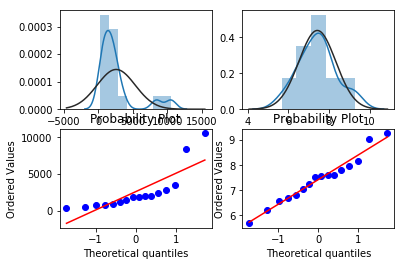

In [20]:
draw2by2log(df2['is_goal'])

In [21]:
# As we can see here is_goal models out ot be roughly the same probability as shooting percentage

In [22]:
dataComplete.head()


,game_id,x,y,period,periodTime,event,secondaryType,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,distance,trueShotPercent,zone1,zone2
8,2012030221,73.0,-8.0,1,35,Blocked Shot,NaN,0,0,1,0,0,0,0,0,0,17.888544,8.388211,2,R-Slot
12,2012030221,67.0,-11.0,1,74,Blocked Shot,NaN,0,0,1,0,0,0,0,0,0,24.596748,4.856358,3,R-2
15,2012030221,56.0,37.0,1,132,Shot,Snap Shot,0,1,0,0,1,0,0,0,0,49.578221,2.291195,5,L-1
16,2012030221,34.0,32.0,1,139,Shot,Slap Shot,0,1,0,0,0,1,0,0,0,63.631753,1.198118,6,L-Point
18,2012030221,36.0,34.0,1,170,Shot,Wrist Shot,0,1,0,0,0,0,1,0,0,62.968246,1.198118,6,L-Point


In [23]:
train_dist = dataComplete[['period','is_goal','is_shot','trueShotPercent','zone1']].copy()

In [24]:
train_dist.head()

,period,is_goal,is_shot,trueShotPercent,zone1
8,1,0,0,8.388211,2
12,1,0,0,4.856358,3
15,1,0,1,2.291195,5
16,1,0,1,1.198118,6
18,1,0,1,1.198118,6


In [25]:
dummy_fields = ['zone1']
for field in dummy_fields:
    dummies = pd.get_dummies(train_dist.loc[:, field], prefix=field)
    train_dist = pd.concat([train_dist, dummies], axis = 1)


In [26]:
train_dist.head(n=5)

,period,is_goal,is_shot,trueShotPercent,zone1,zone1_1,zone1_2,zone1_3,zone1_4,zone1_5,zone1_6,zone1_7,zone1_8
8,1,0,0,8.388211,2,0,1,0,0,0,0,0,0
12,1,0,0,4.856358,3,0,0,1,0,0,0,0,0
15,1,0,1,2.291195,5,0,0,0,0,1,0,0,0
16,1,0,1,1.198118,6,0,0,0,0,0,1,0,0
18,1,0,1,1.198118,6,0,0,0,0,0,1,0,0


In [27]:
print("The dimension for the input of distance-based model is %d x %d" % (train_dist.shape[0], train_dist.shape[1] - 1))

The dimension for the input of distance-based model is 832277 x 12


In [28]:
random_state = 7

In [52]:
xt_train_test, xt_valid, yt_train_test, yt_valid = train_test_split(train_dist['trueShotPercent'], train_dist.drop('trueShotPercent', axis=1), test_size=.2, random_state=random_state)
xd_train_test, xd_valid, yd_train_test, yd_valid = train_test_split(train_dist['trueShotPercent'], train_dist.drop('trueShotPercent', axis=1), test_size=.2, random_state=random_state)

In [53]:
xt_train, xt_test, yt_train, yt_test = train_test_split(yt_train_test, xt_train_test, test_size=.2, random_state=random_state)
xd_train, xd_test, yd_train, yd_test = train_test_split(yd_train_test, xd_train_test, test_size=.2, random_state=random_state)


In [54]:
print("number of training set: %d\nnumber of testing set: %d\nnumber of validation set: %d\ntotal: %d" % (len(xt_train), len(xt_test), len(xt_valid), (len(xt_train)+len(xt_test)+len(xt_valid))))


number of training set: 532656
number of testing set: 133165
number of validation set: 166456
total: 832277


In [55]:
def rmse(arr1, arr2):
    return np.sqrt(np.mean((arr1-arr2)**2))


RMSE for Linear Regression Model in sklearn: 0.00


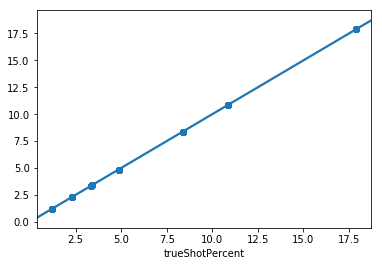

In [56]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(xd_train, yd_train)
yd_lm = lm.predict(xd_test)
rmse_linear = rmse(yd_test, yd_lm)
sns.regplot(yd_test, yd_lm)
print("RMSE for Linear Regression Model in sklearn: %.2f" % rmse_linear)

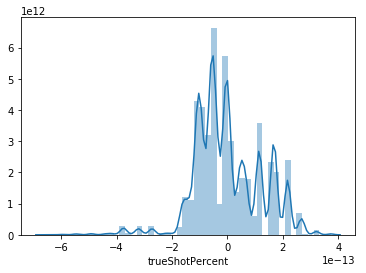

In [57]:
sns.distplot(yd_test-yd_lm)

In [35]:
#Linear regression is a difficult model used to predict whether or not something is a discrete value that can only be one goal or not a goal.
#The value that we've ended up with

# Using Naive Bayes Classifier

In [36]:
dfnb = dataComplete[['period','is_goal','is_shot','BlockedShot','MissedShot','SnapShot','SlapShot','WristShot','Tip','Deflected','zone1', 'trueShotPercent']].copy()

In [37]:
dfnb

,period,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,zone1,trueShotPercent
8,1,0,0,1,0,0,0,0,0,0,2,8.388211
12,1,0,0,1,0,0,0,0,0,0,3,4.856358
15,1,0,1,0,0,1,0,0,0,0,5,2.291195
16,1,0,1,0,0,0,1,0,0,0,6,1.198118
18,1,0,1,0,0,0,0,1,0,0,6,1.198118
19,1,0,0,1,0,0,0,0,0,0,5,2.291195
23,1,0,1,0,0,0,0,0,0,0,2,8.388211
28,1,0,0,1,0,0,0,0,0,0,4,3.412389
29,1,0,0,0,1,0,0,0,0,0,2,8.388211
30,1,0,0,0,1,0,0,0,0,0,5,2.291195


In [38]:
mnb= MultinomialNB()


In [39]:
data = dataComplete[["period", "is_shot", "is_goal", "BlockedShot","MissedShot","SnapShot","SlapShot","WristShot","Tip","Deflected","zone1","trueShotPercent"]]
X_train, X_test = train_test_split(data, test_size=0.5, random_state=int(time.time()))

In [64]:
used_features =[
    "period",
    "is_shot",
    "BlockedShot",
    "MissedShot",
    "SnapShot",
    "SlapShot",
    "WristShot",
    "Tip",
    "Deflected",
    "zone1",
]

In [65]:
mnb.fit(
    X_train[used_features].values,
    X_train["is_goal"]
)
y_pred = mnb.predict(X_test[used_features])

In [67]:
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["is_goal"] != y_pred).sum(),
          100*(1-(X_test["is_goal"] != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 416139 points : 20634, performance 95.04%


In [68]:
gnb = GaussianNB()
gnb.fit(
    X_train[used_features].values,
    X_train["is_goal"]
)
y_pred = gnb.predict(X_test[used_features])   


In [69]:
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["is_goal"] != y_pred).sum(),
          100*(1-(X_test["is_goal"] != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 416139 points : 0, performance 100.00%


In [70]:
bnb = BernoulliNB()
bnb.fit(
    X_train[used_features].values,
    X_train["is_goal"] 
)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [71]:
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (X_test["is_goal"] != y_pred).sum(),
          100*(1-(X_test["is_goal"] != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 416139 points : 0, performance 100.00%


# Running the data with an Adaboost classifier

In [44]:
dfnb

,period,is_goal,is_shot,BlockedShot,MissedShot,SnapShot,SlapShot,WristShot,Tip,Deflected,zone1,trueShotPercent
8,1,0,0,1,0,0,0,0,0,0,2,8.388211
12,1,0,0,1,0,0,0,0,0,0,3,4.856358
15,1,0,1,0,0,1,0,0,0,0,5,2.291195
16,1,0,1,0,0,0,1,0,0,0,6,1.198118
18,1,0,1,0,0,0,0,1,0,0,6,1.198118
19,1,0,0,1,0,0,0,0,0,0,5,2.291195
23,1,0,1,0,0,0,0,0,0,0,2,8.388211
28,1,0,0,1,0,0,0,0,0,0,4,3.412389
29,1,0,0,0,1,0,0,0,0,0,2,8.388211
30,1,0,0,0,1,0,0,0,0,0,5,2.291195


In [45]:
Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1)

In [46]:
X = dfnb.drop('is_goal',axis=1)

In [47]:
Y = dfnb['is_goal'].where(dfnb['is_goal']==1,-1)

In [48]:
predictions = np.mean(cross_validate(Tree_model,X,Y,cv=100)['test_score'])

In [49]:
print('The accuracy is: ',predictions*100,'%',sep="")

The accuracy is: 95.03446611670526%


In [50]:
AdaBoost = AdaBoostClassifier(n_estimators=400,learning_rate=1,algorithm='SAMME')
AdaBoost.fit(X,Y)
prediction = AdaBoost.score(X,Y)
print('The accuracy is: ',prediction*100,'%')

The accuracy is:  100.0 %


In [51]:
#As we can see with a decision stump formula we get an accuracy model of 95.03% which is a slight improvement on the
#multinomial naive bayes formula. The AdaBoost Classifier is able to determine an accuracy tree model of 100%